<a class="anchor" id="top"></a>

# Topic Modeling with LDA to Generate Target Risk Topics
Author: Ainesh Pandey

In this notebook, we will perform topic modeling using [LDA (Latent Dirichlet Allocation)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) on the _Lesson(s) Learned_ column of the `lessons_learned.csv` dataframe. The purpose of this analysis is to attempt to organize the different projects into risk topics. Assuming the LDA model produces reasonable topics, we can use the topic classification as ground truth in a modeling objective.

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Text Preprocessing](#step-2) <br>
[Step 3: Tuning Number of Topics](#step-3) <br>
[Step 4: Categorization of Projects into Risk Topics](#step-4) <br>
[Step 5: Visualizations and Results](#step-5) <br>
[Step 6: Save Risk Classifications to CSV](#step-6) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
# basic data science packages
import pandas as pd
import numpy as np
from operator import itemgetter
np.random.seed(5)

# gensim packages for text preprocessing and LDA
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

# nltk packages for text preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

# visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ainesh93/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ainesh93/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data
We import `lessons_learned.csv` and keep only information from the _Lesson(s) Learned_ column.

In [2]:
df = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv',
                 usecols=['Lesson ID', 'Lesson(s) Learned'], encoding='cp1252')
df = df[df['Lesson(s) Learned'].notna()]

display(df.shape)
df.head()

(2086, 2)

,Lesson ID,Lesson(s) Learned
0,30004,Approach 1 made it difficult to understand the...
1,30101,As a result of many years of expensive lessons...
2,29801,There was an unexpectedly wide variation in el...
3,29702,"If possible, the design phase of both systems ..."
4,29103,The pinch was initially visually inspected and...


[Back to Top](#top)

<a class="anchor" id="step-2"></a>

## Text Preprocessing

First, we develop the prepocessing function that:
- calls the `gensim` *simple_preprocess* function
- removes stopwords and words shorter than three letters
- stems and lemmatizes the words

In [3]:
def preprocess(text):
    stemmer = PorterStemmer()
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')))
    return result

processed_lessons = df['Lesson(s) Learned'].map(preprocess)

print('Original text')
print(df.iloc[0,1])
print()
print('Processed text')
print(processed_lessons[:1][0])

Original text
Approach 1 made it difficult to understand the complete risk profile of the project because risks were split between the contractor and the government risk registers. Subsequently, approach 2 provided greater ongoing awareness to the risks owned by the contractor; however, it did not result in significant improvement to the government mitigation of those risks. Disagreements on the assessment, handling, or closure of risks owned by the contractor were at times strained. Finally, approach 3 placed the responsibility on the government to identify, track, and assess handling plans for all risks to the project, utilizing the contractor process more as a source of information rather than the responsible authority for instrument development risk management. This change resulted in an increase to Government tracked risks but allowed the government to better manage and understand the project risk posture.

Processed text
['approach', 'difficult', 'understand', 'complet', 'risk', 

Next, we need to create the data structures required by the LDA package.
- dictionary: contains all of the post-processed terms in the corpus, subject to certain conditions
- corpus_bow: a bag-of-words representation of each document
- corpus_tfidf: converts the bag-of-words representation into a TFIDF (term-frequency-inverse-document-frequency) representation

In [4]:
# create dictionary, keep only terms that occur more than 10 times and in less than half of the documents, keeping a max of 100000 terms
dictionary = gensim.corpora.Dictionary(processed_lessons)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# create the corpus_bow
corpus_bow = [dictionary.doc2bow(doc) for doc in processed_lessons]

# create the corpus_tfidf
tfidf_model = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf_model[corpus_bow]

# display the first document
print('Original text')
print(df.iloc[0,1])
print()

# visualize the first 5 elements of the corpus_bow for the first document
print('Bag-of-words Representation')
print(corpus_bow[0])
print()

# visualize the tfidf representation of the first document
print('TF-IDF Representation')
print(corpus_tfidf[0])


Original text
Approach 1 made it difficult to understand the complete risk profile of the project because risks were split between the contractor and the government risk registers. Subsequently, approach 2 provided greater ongoing awareness to the risks owned by the contractor; however, it did not result in significant improvement to the government mitigation of those risks. Disagreements on the assessment, handling, or closure of risks owned by the contractor were at times strained. Finally, approach 3 placed the responsibility on the government to identify, track, and assess handling plans for all risks to the project, utilizing the contractor process more as a source of information rather than the responsible authority for instrument development risk management. This change resulted in an increase to Government tracked risks but allowed the government to better manage and understand the project risk posture.

Bag-of-words Representation
[(0, 1), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1

[Back to Top](#top)

<a class="anchor" id="step-3"></a>

## Tuning Number of Topics

Identifying the ideal number of topics is a key step of LDA. We will test different number of topics through brute-force, using a coherence value to identify how distinct the different topics are for each iteration. We will start with two (2) topics, and test up to twenty (20) topics.

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = [0 for n in range(start)]

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, chunksize=100,
                                           random_state=5, passes=10, workers=4, per_word_topics=True)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('Done modeling for num_topics = {}, Coherence score: {}'.format(num_topics, coherencemodel.get_coherence()))

    return coherence_values

coherence_values = compute_coherence_values(dictionary, corpus_tfidf, processed_lessons, 16, start=2, step=1)

Done modeling for num_topics = 2, Coherence score: 0.3709537531667457
Done modeling for num_topics = 3, Coherence score: 0.3538182049530687
Done modeling for num_topics = 4, Coherence score: 0.3358717741570828
Done modeling for num_topics = 5, Coherence score: 0.4040893746372462
Done modeling for num_topics = 6, Coherence score: 0.4187047032920357
Done modeling for num_topics = 7, Coherence score: 0.5073776069461298
Done modeling for num_topics = 8, Coherence score: 0.46321849867650683
Done modeling for num_topics = 9, Coherence score: 0.46425666363982415
Done modeling for num_topics = 10, Coherence score: 0.4792281684260429
Done modeling for num_topics = 11, Coherence score: 0.44473216253129433
Done modeling for num_topics = 12, Coherence score: 0.4407236110983608
Done modeling for num_topics = 13, Coherence score: 0.5065704311305125
Done modeling for num_topics = 14, Coherence score: 0.5246948931535228
Done modeling for num_topics = 15, Coherence score: 0.47885046142884796


An accepted practice used to identify the number of topics is the "elbow method". We will visualize the coherence scores across number of topics to identify the elbow.

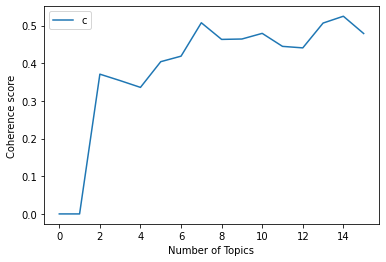

In [15]:
# Show graph
plt.plot(range(0, 16, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

According to the graph, the "elbow" is at 5 topics.

In [16]:
lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=5, chunksize=100,
                                       random_state=10, passes=10, workers=4, per_word_topics=True)
lda_model7 = gensim.models.LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=7, chunksize=100,
                                       random_state=10, passes=10, workers=4, per_word_topics=True)

[Back to Top](#top)

<a class="anchor" id="step-4"></a>

## Categorization of Projects into Risk Topics

We now categorize each lesson learned into one of the 5 topics, which will represent the risk classification.

In [17]:
df['Risk Class']  = [max(lda_model[corpus_tfidf[n]][0], key=itemgetter(1))[0] for n in range(len(corpus_tfidf))]
df['Risk Class7']  = [max(lda_model7[corpus_tfidf[n]][0], key=itemgetter(1))[0] for n in range(len(corpus_tfidf))]

display(df.shape)
df.head()

(2086, 4)

,Lesson ID,Lesson(s) Learned,Risk Class,Risk Class7
0,30004,Approach 1 made it difficult to understand the...,4,4
1,30101,As a result of many years of expensive lessons...,4,4
2,29801,There was an unexpectedly wide variation in el...,4,4
3,29702,"If possible, the design phase of both systems ...",4,4
4,29103,The pinch was initially visually inspected and...,4,4


[Back to Top](#top)

<a class="anchor" id="step-5"></a>

## Visualizations and Results

### Visualizations

Let's examine the results of our risk classification. First, let's visualize the distribution of the risk classes.

4    1459
0     385
2     212
3      19
1      11
Name: Risk Class, dtype: int64

Text(0.5, 1.0, 'Distribution of Risk Class')

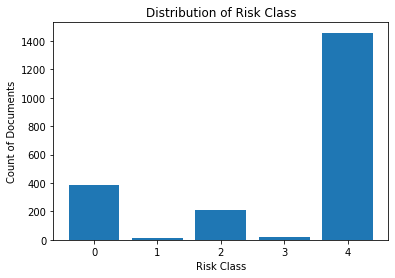

In [18]:
dist = df['Risk Class'].value_counts()
display(dist)

plt.bar(dist.index, dist)
plt.xlabel('Risk Class')
plt.ylabel('Count of Documents')
plt.title('Distribution of Risk Class')

4    1333
6     245
3     161
5     158
0     135
2      30
1      24
Name: Risk Class7, dtype: int64

Text(0.5, 1.0, 'Distribution of Risk Class')

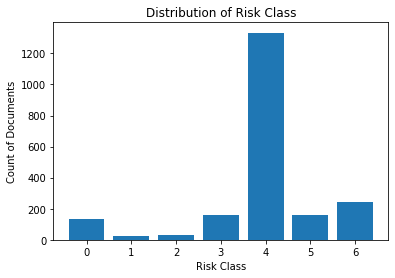

In [19]:
dist = df['Risk Class7'].value_counts()
display(dist)

plt.bar(dist.index, dist)
plt.xlabel('Risk Class')
plt.ylabel('Count of Documents')
plt.title('Distribution of Risk Class')

The distribution is very uneven, but this may not necessarily be a bad thing. The inputs used are non-standardized free-text in human English. It is possible that there are very few identifying features for specific risk profiles. We need to further examine the composition of the documents within each topic to see if certain trends emerge.

Let's view the functions created to calculate the probability of a document from the _Lesson(s) Learned_ column belonging to a certain topic.

In [20]:
for idx, risk_class in lda_model.print_topics(-1):
    print('Risk Class: {} \n   {}'.format(idx, risk_class))

Risk Class: 0 
   0.015*"damag" + 0.013*"pressur" + 0.012*"result" + 0.012*"caus" + 0.010*"valv" + 0.010*"failur" + 0.009*"electr" + 0.008*"pump" + 0.008*"posit" + 0.008*"leak"
Risk Class: 1 
   0.019*"payload" + 0.013*"aviat" + 0.012*"wast" + 0.011*"portabl" + 0.011*"escap" + 0.011*"antenna" + 0.010*"concurr" + 0.010*"disrupt" + 0.009*"reserv" + 0.009*"pilot"
Risk Class: 2 
   0.017*"failur" + 0.011*"result" + 0.010*"loss" + 0.010*"injuri" + 0.010*"circuit" + 0.009*"compon" + 0.009*"materi" + 0.009*"caus" + 0.008*"mission" + 0.008*"spacecraft"
Risk Class: 3 
   0.038*"lift" + 0.030*"attach" + 0.024*"hydraul" + 0.015*"elev" + 0.014*"solder" + 0.014*"wall" + 0.013*"blade" + 0.012*"uncontrol" + 0.012*"heavi" + 0.011*"uplink"
Risk Class: 4 
   0.009*"test" + 0.007*"project" + 0.007*"oper" + 0.007*"requir" + 0.007*"design" + 0.006*"flight" + 0.006*"program" + 0.006*"process" + 0.005*"mission" + 0.005*"develop"


In [21]:
for idx, risk_class in lda_model7.print_topics(-1):
    print('Risk Class: {} \n   {}'.format(idx, risk_class))

Risk Class: 0 
   0.025*"valv" + 0.016*"pressur" + 0.015*"line" + 0.013*"caus" + 0.013*"damag" + 0.013*"result" + 0.012*"purg" + 0.012*"propel" + 0.011*"switch" + 0.011*"close"
Risk Class: 1 
   0.039*"lift" + 0.029*"crane" + 0.019*"actuat" + 0.016*"thermal" + 0.016*"injuri" + 0.015*"transport" + 0.014*"damag" + 0.012*"personnel" + 0.011*"load" + 0.010*"portabl"
Risk Class: 2 
   0.024*"attach" + 0.021*"rocket" + 0.018*"solid" + 0.016*"segment" + 0.015*"fit" + 0.014*"toler" + 0.013*"injuri" + 0.012*"danger" + 0.012*"combust" + 0.012*"metal"
Risk Class: 3 
   0.014*"power" + 0.012*"damag" + 0.010*"circuit" + 0.010*"caus" + 0.010*"voltag" + 0.010*"pump" + 0.010*"motor" + 0.010*"hydraul" + 0.009*"wire" + 0.009*"connector"
Risk Class: 4 
   0.009*"test" + 0.008*"project" + 0.008*"design" + 0.007*"mission" + 0.007*"flight" + 0.007*"oper" + 0.007*"requir" + 0.006*"process" + 0.006*"program" + 0.005*"time"
Risk Class: 5 
   0.009*"requir" + 0.007*"oper" + 0.007*"test" + 0.007*"hardwar" + 0.00

We may need to access the key terms for each topic. Let's arrange them into a dataframe.

In [24]:
# create the dataframe
df_riskclass_terms = pd.DataFrame()

# for each of the 5 topics, add their key term indices and coefficients to the dataframe
for risk_class in range(7):
    temp = pd.DataFrame(lda_model7.get_topic_terms(risk_class))
    temp['Risk Class'] = risk_class
    df_riskclass_terms = pd.concat([df_riskclass_terms, temp], axis=0)

# add a column for the term referred to by each term index
df_riskclass_terms['Term'] = [dictionary[x] for x in df_riskclass_terms[0]]

# rearrange columns to be more intuitive
df_riskclass_terms.columns = ['Term Index', 'Term Coefficient', 'Risk Class', 'Term']
df_topic_terms = df_riskclass_terms[['Risk Class', 'Term Index', 'Term', 'Term Coefficient']]

display(df_riskclass_terms.shape)
df_riskclass_terms.head()

(70, 4)

,Term Index,Term Coefficient,Risk Class,Term
0,391,0.025355,0,valv
1,593,0.016185,0,pressur
2,398,0.014701,0,line
3,63,0.013262,0,caus
4,86,0.013141,0,damag


Now, let's visualize the key terms of each topic next to the terms from all of the documents within.

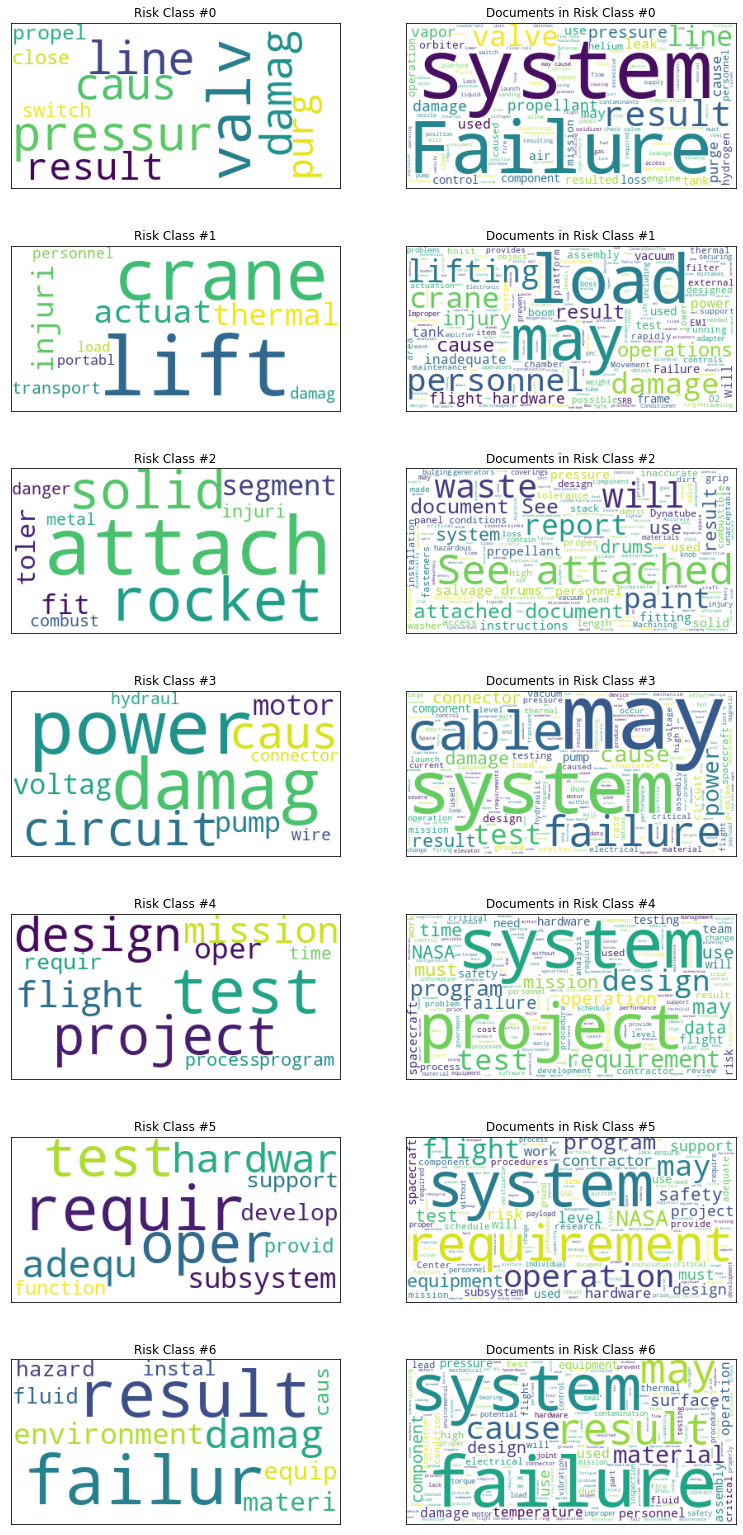

In [26]:
df_riskclass_terms.index = df_riskclass_terms['Term']
fig, ax = plt.subplots(7,2, figsize = (13,28))

for risk_class in range(7):
    temp_riskclass = df_riskclass_terms[df_riskclass_terms['Risk Class'] == risk_class]
    temp_docs      = ' '.join(df[df['Risk Class7'] == risk_class]["Lesson(s) Learned"])
    temp_topic_cloud = WordCloud(background_color='white').generate_from_frequencies(temp_riskclass['Term Coefficient'])
    temp_docs_cloud  = WordCloud(background_color='white').generate(temp_docs)

    ax[risk_class,0].axes.xaxis.set_visible(False)
    ax[risk_class,0].axes.yaxis.set_visible(False)
    ax[risk_class,0].title.set_text('Risk Class #{}'.format(risk_class))
    ax[risk_class,0].imshow(temp_topic_cloud)

    ax[risk_class,1].axes.xaxis.set_visible(False)
    ax[risk_class,1].axes.yaxis.set_visible(False)
    ax[risk_class,1].title.set_text('Documents in Risk Class #{}'.format(risk_class))
    ax[risk_class,1].imshow(temp_docs_cloud)

### Results

An initial analysis of the topics indicates the following learnings:
- The first three topics seem to be good options for further risk classification.
    - `Risk Class 0`: Catastrophic Failure
        - The most prevalent terms for this topic seem to indicate failure due to some mishap during the project: 'damag', 'pressur', 'failur', 'contam', 'electr', 'leak', etc.
        - Similarly, the most common terms in the documents also indicate 'failur', potentially due to 'system' 'damag'.
        - This
    - `Risk Class 1`: High-Cost Aviation Projects
    - `Risk Class 2`: XYZ
- The most prevalent terms for `Risk Class 3` are 'see', 'document', and 'attached'. It seems highly probable that most of the _Lesson(s) Learned_ here literally "See document attached". There are only 17 documents in this topic, so we will take a look at these manually to see if our hunch is correct.
- `Risk Class 4` seems to be a catch-all for projects with risk that cannot be easily classified. The most prevalent terms in the documents in this topic are generic, as are the key terms in the topic wordcloud as well.

Let's check our hunch about `Risk Class 3`.

In [27]:
df[df['Risk Class'] == 2]

,Lesson ID,Lesson(s) Learned,Risk Class,Risk Class7
21,25503,"After the second reaction wheel failure, only ...",2,4
54,18701,From this experience we learned that: Ensuring...,2,4
57,19501,A crowbar is a fail-safe protection mechanism ...,2,4
61,18401,Pay attention to the weather ahead of time. Th...,2,4
72,17903,1. Foam is not simple; it is not easily modele...,2,4
...,...,...,...,...
2067,400,Spacecraft structural dynamical interactions w...,2,5
2078,367,Post-fire squib shorts can result in anomalous...,2,5
2086,282,Circuits can behave in an unexpected and unacc...,2,4
2088,378,System engineers cannot rely on the individual...,2,5


As expected, the documents classified as `Risk Class 3` are going to be useless for further analysis. We will drop them for the classification portion.

[Back to Top](#top)

<a class="anchor" id="step-6"></a>

## Save Risk Classifications to CSV
We now save the risk classification as a csv for the modeling step.

In [28]:
df.to_csv('../data/risk_classifications7.csv', columns=['Lesson ID', 'Risk Class7'], index=False)

[Back to Top](#top)